<a href="https://colab.research.google.com/github/el-geuse/EE992/blob/main/base_project_verpeter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trying out EfficientNetB0 with Data Augmentation


##Import necessary libraries

In [7]:
%matplotlib inline


#!cat /proc/cpuinfo # gives details of CPU

#!nvidia-smi # gives details of GPU

# TensorFlow and tf.keras
import tensorflow as tf
import keras
from keras.layers import Input, Conv2D, GlobalMaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, GlobalAveragePooling2D
from keras.models import Sequential


# Commonly used modules
import numpy as np
import os, datetime
import sys

# Images, plots, display, and visualization
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import cv2
import IPython
from six.moves import urllib

print(tf.__version__)


from matplotlib.pyplot import imshow

from sklearn.metrics import confusion_matrix

2.15.0


##Load CIFAR100 dataset

In [8]:
from keras.datasets import cifar100
# Capital letters are the ones going to be used, small still need to be processed
(x_train, y_train), (X_test, Y_test)  = cifar100.load_data()

# return the modified images
print("Train Images shape: ",x_train.shape)
print("Test Images shape: ",X_test.shape)
print(y_train.shape)
print(Y_test.shape)

169001437/169001437 [==============================] - 13s 0us/step
Train Images shape:  (50000, 32, 32, 3)
Test Images shape:  (10000, 32, 32, 3)
(50000, 1)
(10000, 1)


# Train Validation Split
Splitting the training data up into both validation and testing data. Useful to have some validation data to allow for tuning of hyperparameters. Using StratifiedShuffleSplit as 500 images for eqch class has a small chance to skew it, so ensuring stratification is vital.

In [9]:

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

st = StratifiedShuffleSplit(n_splits = 2, test_size = 0.2, random_state = 1)

for train_index, val_index in st.split(x_train, y_train):
    X_train, X_val, Y_train, Y_val = x_train[train_index], x_train[val_index], y_train[train_index], y_train[val_index]

print("Train Images shape: ",X_train.shape)
print("Validation Images shape: ",X_val.shape)

del x_train, y_train

Train Images shape:  (40000, 32, 32, 3)
Validation Images shape:  (10000, 32, 32, 3)


##Preprocess Image Data
Trying out some data augmentation stuff with [albumentations](https://github.com/albumentations-team/albumentations).

In [10]:
import albumentations as albu
from keras.utils import to_categorical

def np_resize(img, shape):
    return cv2.resize(img, (shape[1], shape[0]), interpolation = cv2.INTER_CUBIC)

# Parameters for data generator
height = 224
width = 224
channels = 3
input_shape = (height, width, channels)
n_classes = 100
batch_size = 8

class DataGenerator(keras.utils.Sequence):
    'Generates data for keras'
    def __init__(self, images , labels = None, mode = 'fit', batch_size = batch_size,
                 dim = (height, width), channels = channels, n_classes = n_classes,
                 shuffle = True, augment = False):
        self.images = images
        self.labels = labels
        self.mode = mode
        self.batch_size = batch_size
        self.dim = dim
        self.channels = channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.augment = augment

        self.on_epoch_end()

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(self.images.shape[0])
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.images) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        batch_indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # =========================================================== #
        # Generate mini-batch of X
        # =========================================================== #
        X = np.empty((self.batch_size, *self.dim, self.channels))
        for i, ID in enumerate(batch_indexes):
            # Generate a preprocessed image
            img = self.images[ID]
            # For some reason this line completely messes up the validation accuracy?
            # img = img.astype(np.float32) / 255.
            img = np_resize(img, self.dim)
            X[i] = img


        # =========================================================== #
        # Generate mini-batch of y
        # =========================================================== #
        if self.mode == 'fit':
            y = self.labels[batch_indexes]
            y = to_categorical(y, n_classes)
            '''
            y = np.zeros((self.batch_size, self.n_classes), dtype = np.uint8)
            for i, ID in enumerate(batch_indexes):
                # one hot encoded label
                y[i, self.labels[ID]] = 1
            '''
            # Augmentation should only be implemented in the training part.
            if self.augment == True:
                X = self.__augment_batch(X)

            return X,y

        elif self.mode == 'predict':
            return X

        else:
            raise AttributeError('The mode parameters should be set to "fit" or "predict"')

    def __random_transform(self, img):
        composition = albu.Compose([albu.HorizontalFlip(p = 0.5),
                                    albu.VerticalFlip(p = 0.5),
                                    albu.GridDistortion(p = 0.2),
                                    albu.ElasticTransform(p = 0.2)])

        return composition(image = img)['image']


    def __augment_batch(self, img_batch):
        for i in range(img_batch.shape[0]):
            img_batch[i] = self.__random_transform(img_batch[i])

        return img_batch


# Create a generator object for the training images.
train_generator = DataGenerator(X_train, Y_train, augment = True)

# Create a generator object for the validation images.
validation_generator = DataGenerator(X_val, Y_val, augment = False)

Yeah I really beefed this up. Can scale it down if necessary. Essentially creates an object that can be called to create batches later on in the data. Handles resizing, rescaling and data augmentation, a cool function!

## Analysing Model with EfficientNetB0
Taken mostly from [here](https://www.kaggle.com/code/micajoumathematics/fine-tuning-efficientnetb0-on-cifar-100/notebook)

In [11]:
from keras.applications.efficientnet import EfficientNetB0

efmodel = EfficientNetB0(weights='imagenet',
                              include_top=False,
                              classes=100,
                              input_shape=input_shape)

# If model is to be frozen
# efmodel.trainable = false

In [12]:
model = Sequential()
model.add(efmodel)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.4))
model.add(Dense(100, activation = 'softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 7, 7, 1280)        4049571   
 )                                                               
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 100)               128100    
                                                                 
Total params: 4177671 (15.94 MB)
Trainable params: 4135648 (15.78 MB)
Non-trainable params: 42023 (164.16 KB)
_________________________________________________________________


In [13]:
from google.colab import drive
drive.mount('/content/drive')

import os

from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam, SGD
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define the directory where you want to save your model checkpoints
checkpoint_dir = "/content/drive/MyDrive/Colab_Model_Checkpoints"

# Create the directory if it doesn't exist
os.makedirs(checkpoint_dir, exist_ok=True)


# Define the model checkpoint path with the dynamic epoch number
model_checkpoint_path = os.path.join(checkpoint_dir, "model_checkpoint_epoch_{epoch:02d}.hdf5")

# Set up the ModelCheckpoint callback
model_checkpoint_callback = ModelCheckpoint(
    filepath=model_checkpoint_path,
    save_weights_only=False,  # Change to True if you only want to save weights
    save_best_only=False,     # Set to True to save only the best model according to some metric
    verbose=1,                # Log a message for each time a model is saved
)


optimizer = SGD(learning_rate = 1e-3, momentum = 0.9, nesterov = True)
# optimizer = Adam(learning_rate=0.0001)
es = EarlyStopping(monitor = 'val_loss', mode = 'min', patience = 10, restore_best_weights = True, verbose = 1)
rlrop = ReduceLROnPlateau(monitor = 'val_loss', mode = 'min', patience = 5, factor = 0.5, min_lr = 1e-6, verbose = 1)

model.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics = ['acc'])


Mounted at /content/drive


# Actually running the thing


In [15]:
model.load_weights("/content/drive/MyDrive/Colab_Model_Checkpoints/model_checkpoint_epoch_15.hdf5")

In [14]:
model.load_weights("best_weight.h5")

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = 'best_weight.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
# Set to 2 epochs to continue a previous run.
history1 = model.fit(train_generator, validation_data = validation_generator, epochs = 15, verbose = 1, callbacks = [es, rlrop, model_checkpoint_callback])
# history1 = model.fit(train_generator, validation_data = validation_generator, epochs = 15, verbose = 1, callbacks = [es, rlrop])

model.save_weights("best_weight.h5")

Epoch 1/15
5000/5000 [==============================] - ETA: 0s - loss: 2.9675 - acc: 0.2875
Epoch 1: saving model to /content/drive/MyDrive/Colab_Model_Checkpoints/model_checkpoint_epoch_01.hdf5
5000/5000 [==============================] - 702s 137ms/step - loss: 2.9675 - acc: 0.2875 - val_loss: 1.2364 - val_acc: 0.6435 - lr: 0.0010
Epoch 2/15
5000/5000 [==============================] - ETA: 0s - loss: 1.7704 - acc: 0.5167
Epoch 2: saving model to /content/drive/MyDrive/Colab_Model_Checkpoints/model_checkpoint_epoch_02.hdf5
5000/5000 [==============================] - 693s 139ms/step - loss: 1.7704 - acc: 0.5167 - val_loss: 0.9371 - val_acc: 0.7271 - lr: 0.0010
Epoch 3/15
5000/5000 [==============================] - ETA: 0s - loss: 1.4685 - acc: 0.5899
Epoch 3: saving model to /content/drive/MyDrive/Colab_Model_Checkpoints/model_checkpoint_epoch_03.hdf5
5000/5000 [==============================] - 672s 134ms/step - loss: 1.4685 - acc: 0.5899 - val_loss: 0.8279 - val_acc: 0.7534 - lr:

**Record the amount of time it takes to run**

In [16]:
hist = pd.DataFrame(history1.history)
# write all of the data to excel
hist.to_excel("excel_higher_eta.xlsx", sheet_name = "Sheet1")
# doesn't record how long the training takes so either do it manually like me or figure out a way to record the computational time - good as another comparison metric

NameError: name 'history1' is not defined

In [ ]:
model.save(MODEL_PATH)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


**Remember to download the excel file & model as soon as it finishes running**

NameError: name 'history1' is not defined

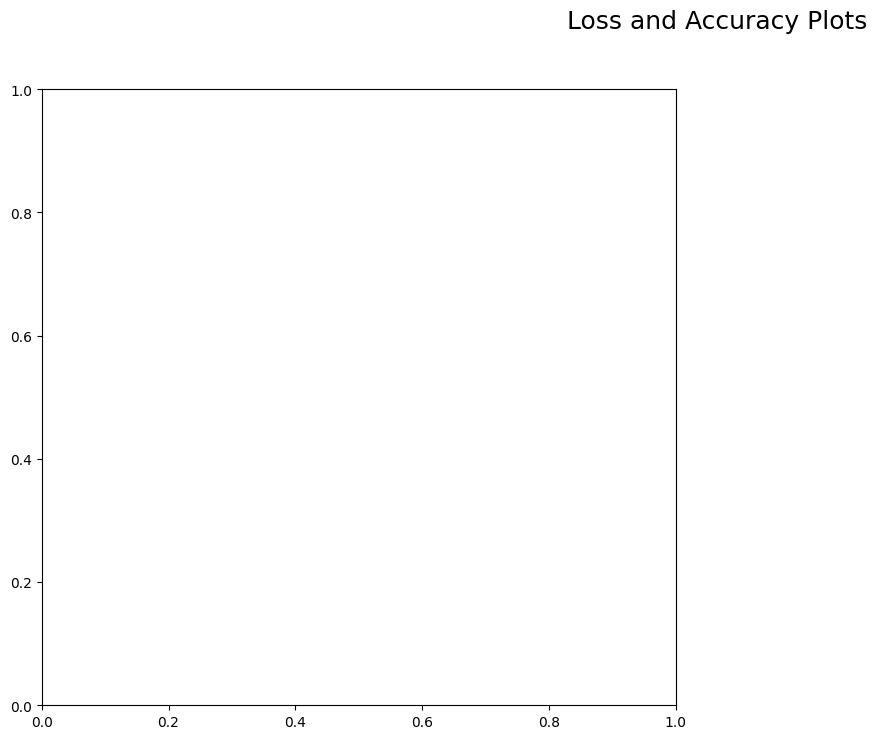

In [17]:
#plot to visualize the loss and accuracy against number of epochs
plt.figure(figsize=(18,8))

plt.suptitle('Loss and Accuracy Plots', fontsize=18)

plt.subplot(1,2,1)
plt.plot(history1.history['loss'], label='Training Loss')
plt.plot(history1.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Number of epochs', fontsize=15)
plt.ylabel('Loss', fontsize=15)

plt.subplot(1,2,2)
plt.plot(history1.history['acc'], label='Train Accuracy')
plt.plot(history1.history['val_acc'], label='Validation Accuracy')
plt.legend()
plt.xlabel('Number of epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.show()

In [19]:
print("The Accuracy on the validation data : {:.2f}%".format(100 * model.evaluate_generator(validation_generator, verbose = 1)[-1]))

<ipython-input-19-96f0b4c920fc>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  print("The Accuracy on the validation data : {:.2f}%".format(100 * model.evaluate_generator(validation_generator, verbose = 1)[-1]))


1250/1250 [==============================] - 34s 22ms/step - loss: 0.7027 - acc: 0.8065
The Accuracy on the validation data : 80.65%


In [20]:
from sklearn.metrics import accuracy_score
# Make sure to set shuffle be False.
test_generator = DataGenerator(X_test, mode = 'predict', augment = False, shuffle = False)
Y_pred = model.predict_generator(test_generator,verbose = 1)
Y_pred = np.argmax(Y_pred, axis = 1)

print("The accuracy on the testing data : {:.2f}%".format(100 * accuracy_score(Y_test, Y_pred)))


<ipython-input-20-7fced0703655>:4: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = model.predict_generator(test_generator,verbose = 1)


1250/1250 [==============================] - 26s 19ms/step
The accuracy on the testing data : 80.85%


**Same thing double check that everything is downloaded before the runtime betrays you**

## Determine the overall model performance in terms of classification on the dataset aka Confusion Matrix

In [ ]:
# Use the trained model on the test dataset
predictions = model.predict(test_generator)
# Normalise the data to set values rather than for each pixel
predictions_for_cm = predictions.argmax(1)

1250/1250 [==============================] - 36s 29ms/step


In [ ]:
# fine mode therefore all of the possible classes must be included
labels = ["apple","aquarium_fish","baby","bear","beaver","bed","bee","beetle","bicycle","bottle","bowl","boy","bridge","bus","butterfly","camel","can","castle","caterpillar","cattle","chair","chimpanzee","clock","cloud","cockroach","couch","crab","crocodile","cup","dinosaur","dolphin","elephant","flatfish","forest","fox","girl","hamster","house","kangaroo","keyboard","lamp","lawn_mower","leopard","lion","lizard","lobster","man","maple_tree","motorcycle","mountain","mouse","mushroom","oak_tree","orange","orchid","otter","palm_tree","pear","pickup_truck","pine_tree","plain","plate","poppy","porcupine","possum","rabbit","raccoon","ray","road","rocket","rose","sea","seal","shark","shrew","skunk","skyscraper","snail","snake","spider","squirrel","streetcar","sunflower","sweet_pepper","table","tank","telephone","television","tiger","tractor","train","trout","tulip","turtle","wardrobe","whale","willow_tree","wolf","woman","worm"]
len(labels)

100

In [ ]:
true_predictions = np.argmax(Y_pred, axis = 1)
true_predictions

AxisError: axis 1 is out of bounds for array of dimension 1

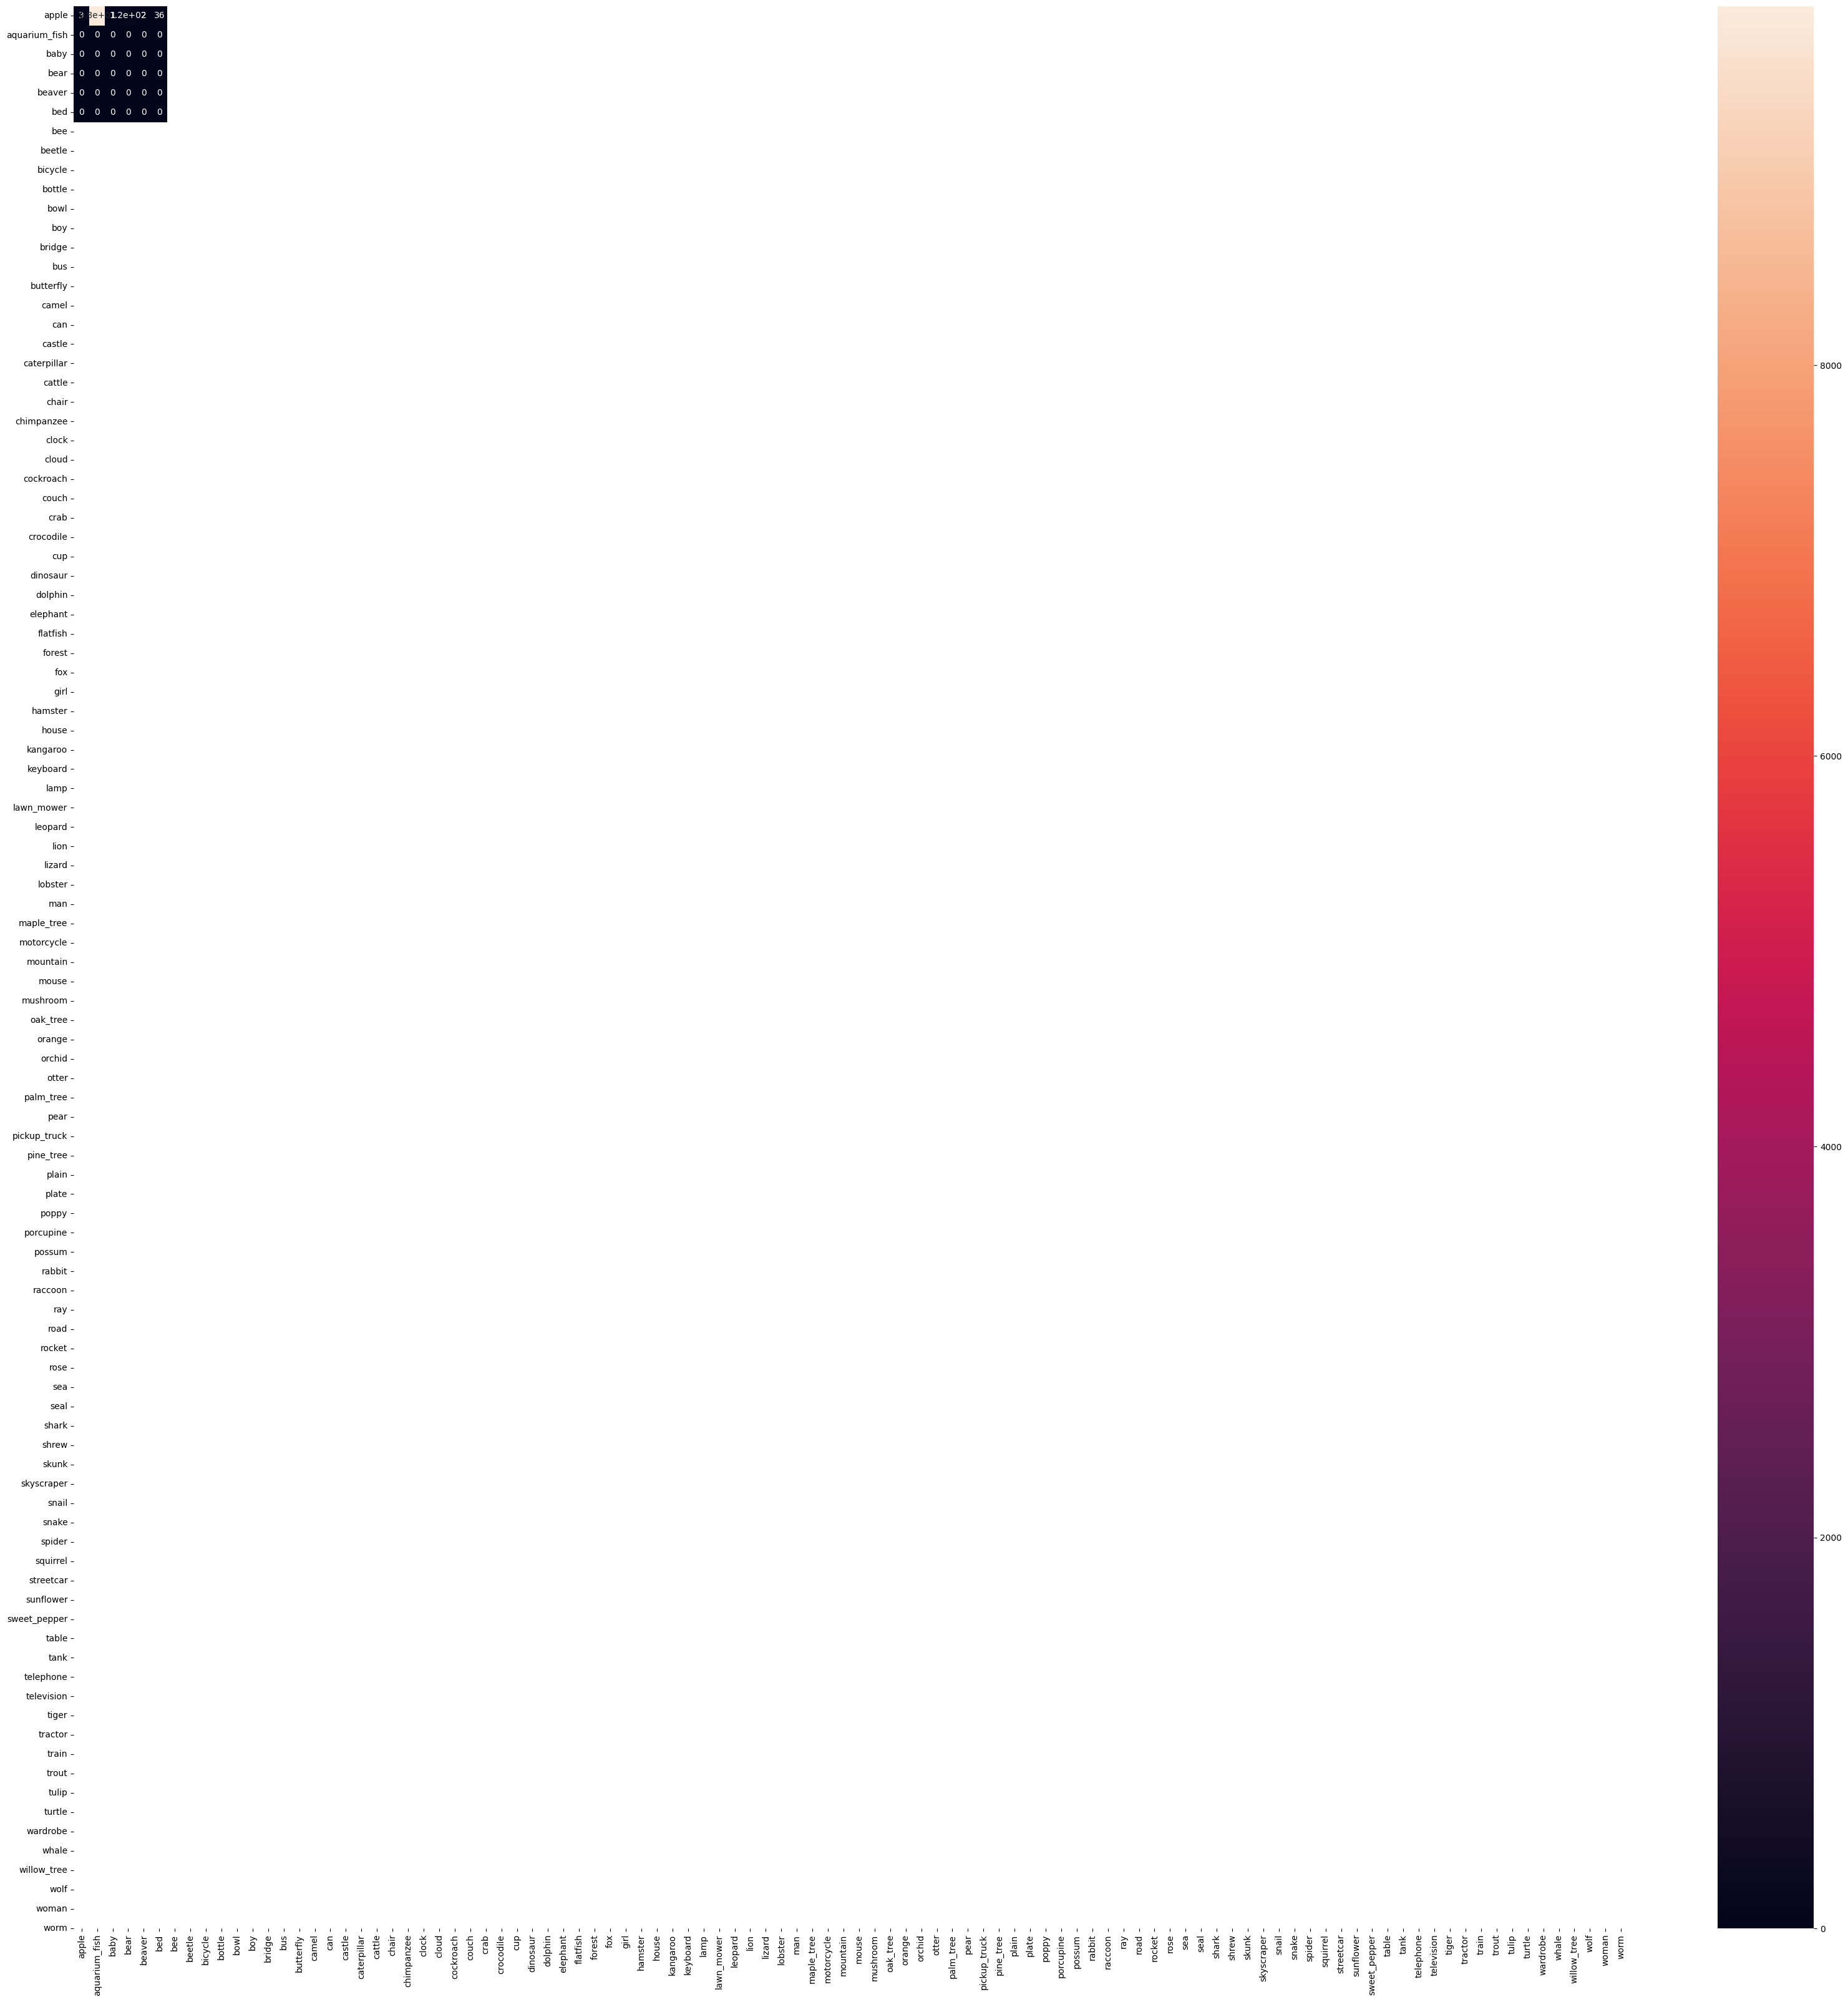

In [ ]:
cm = confusion_matrix(true_predictions, predictions_for_cm)
plt.figure(figsize=(40,40))
plot = sns.heatmap(cm, annot=True,  xticklabels=labels, yticklabels = labels)
fig = plot.get_figure()
fig.savefig("out.png")

**Once again an important output that should be downloaded**

The labels most difficult to distinguish are bear, man, otter, rabbit, seal, squirrel and woman. Is there anything that can be done to make their features more distinct to detect???

In [ ]:
# Ideas?

## Further evaluation metrics - to finish and adapt to this case

https://stackoverflow.com/questions/45332410/roc-for-multiclass-classification

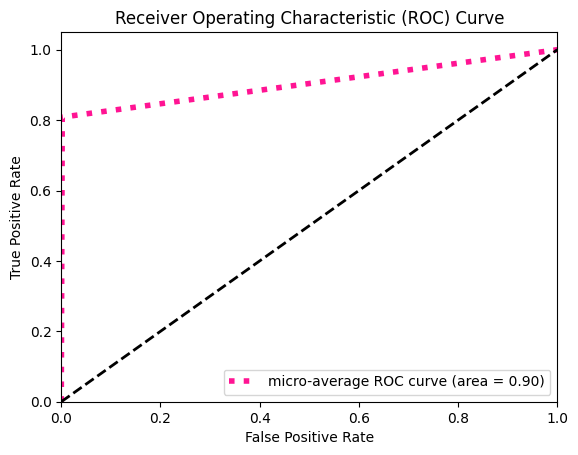

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

n_classes = 100

# Binarize the labels
n_classes = len(np.unique(Y_test))
Y_test_bin = label_binarize(Y_test, classes=np.arange(n_classes))
Y_pred_bin = label_binarize(Y_pred, classes=np.arange(n_classes))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test_bin[:, i], Y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(Y_test_bin.ravel(), Y_pred_bin.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curve
plt.figure()
lw = 2
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]), color='deeppink', linestyle=':', linewidth=4)

# colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
# for i, color in zip(range(n_classes), colors):
#     plt.plot(fpr[i], tpr[i], color=color, lw=lw,
#              label='ROC curve of class {0} (area = {1:0.2f})'
#              ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


Currently time after 10 epoch frozen and 5 epochs unfrozen is: 3652 secs = 60 mins and 52 secs
10 epochs frozen = 1432 secs = 23 mins and 52 secs
5 epochs unfrozen = 2220 secs = 37 mins

##Test Model 1 = DenseNet121 - **rather than like this just replace the VGG16 with the model name so that nothing else needs to be changed**
Selected due to lower size and parameters than baseline model but higher top1 and top5 accuracy likely due to the depth of the Model.

In [ ]:
test_model1 = keras.applications.DenseNet121(include_top=False,
                                        weights='imagenet',
                                        input_shape=(224,224,3),
                                        pooling='max')

test_model1.summary()

29084464/29084464 [==============================] - 0s 0us/step
Model: "densenet121"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 230, 230, 3)          0         ['input_2[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 112, 112, 64)         9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormali

In [ ]:
out = test_model1.output
out = keras.layers.Flatten()(out)
out = keras.layers.BatchNormalization()(out)
out = keras.layers.Dense(256, activation='relu')(out)
out = keras.layers.Dropout(0.3)(out)
out = keras.layers.BatchNormalization()(out)
out = keras.layers.Dense(128, activation='relu')(out)
#out = keras.layers.Dropout(0.3)(out)
#out = keras.layers.BatchNormalization()(out)
#out = keras.layers.Dense(64, activation='relu')(out)
#out = keras.layers.Dropout(0.3)(out)
out = keras.layers.Dense(100, activation='softmax')(out) #key change is that there are 100 output nodes for the 100 classes

In [ ]:
CALLBACKS = []
MODEL_PATH = 'cifar100.h5'

# callbacks
CALLBACKS.append(keras.callbacks.ModelCheckpoint(filepath=MODEL_PATH,
                                              monitor='val_acc',
                                              save_best_only=True))

CALLBACKS.append(keras.callbacks.EarlyStopping(monitor='val_acc',
                                            verbose=1,
                                            patience=5))

CALLBACKS.append(keras.callbacks.TensorBoard(log_dir='logs'))

model = keras.models.Model(inputs, outputs)
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate = 0.001),
              metrics=['accuracy'])

history = model.fit(x=x_train, y=y_train,
                    batch_size=128,
                    epochs=15,
                    validation_data=(x_test, y_test),
                    callbacks=CALLBACKS)

NameError: name 'inputs' is not defined

In [ ]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.plot(history2.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"])
ax2.plot(history2.history["val_accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()
plt.savefig('Test1_model_accuracy.png')

##Test Model 2 = Xception

In [ ]:
test_model2 = keras.applications.Xception(include_top=False,
                                          weights='imagenet',
                                          input_tensor=upscale,
                                          input_shape=(160,160,3),
                                          pooling='max')

test_model2.summary()

NameError: name 'upscale' is not defined

In [ ]:
out = test_model2.output
out = keras.layers.Flatten()(out)
out = keras.layers.BatchNormalization()(out)
out = keras.layers.Dense(256, activation='relu')(out)
out = keras.layers.Dropout(0.3)(out)
out = keras.layers.BatchNormalization()(out)
out = keras.layers.Dense(128, activation='relu')(out)
out = keras.layers.Dropout(0.3)(out)
out = keras.layers.BatchNormalization()(out)
out = keras.layers.Dense(64, activation='relu')(out)
out = keras.layers.Dropout(0.3)(out)
out = keras.layers.Dense(100, activation='softmax')(out) #key change is that there are 100 output nodes for the 100 classes

In [ ]:
CALLBACKS = []
MODEL_PATH = 'cifar100.h5'

# callbacks
CALLBACKS.append(keras.callbacks.ModelCheckpoint(filepath=MODEL_PATH,
                                              monitor='val_acc',
                                              save_best_only=True))

CALLBACKS.append(keras.callbacks.EarlyStopping(monitor='val_acc',
                                            verbose=1,
                                            patience=5))

CALLBACKS.append(keras.callbacks.TensorBoard(log_dir='logs'))

model = keras.models.Model(inputs, outputs)
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate = 0.001),
              metrics=['accuracy'])

history = model.fit(x=x_train, y=y_train,
                    batch_size=128,
                    epochs=15,
                    validation_data=(x_test, y_test),
                    callbacks=CALLBACKS)

In [ ]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.plot(history2.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"])
ax2.plot(history2.history["val_accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()
plt.savefig('Test2_model_accuracy.png')

## Test Model 3 = ResNet101

In [ ]:
test_model3 = keras.applications.ResNet101(include_top=False,
                                          weights='imagenet',
                                          input_tensor=upscale,
                                          input_shape=(160,160,3),
                                          pooling='max')

test_model3.summary()

In [ ]:
out = test_model3.output
out = keras.layers.Flatten()(out)
out = keras.layers.BatchNormalization()(out)
out = keras.layers.Dense(256, activation='relu')(out)
out = keras.layers.Dropout(0.3)(out)
out = keras.layers.BatchNormalization()(out)
out = keras.layers.Dense(128, activation='relu')(out)
out = keras.layers.Dropout(0.3)(out)
out = keras.layers.BatchNormalization()(out)
out = keras.layers.Dense(64, activation='relu')(out)
out = keras.layers.Dropout(0.3)(out)
out = keras.layers.Dense(100, activation='softmax')(out) #key change is that there are 100 output nodes for the 100 classes

NameError: name 'base_model' is not defined

In [ ]:
CALLBACKS = []
MODEL_PATH = 'cifar100.h5'

# callbacks
CALLBACKS.append(keras.callbacks.ModelCheckpoint(filepath=MODEL_PATH,
                                              monitor='val_acc',
                                              save_best_only=True))

CALLBACKS.append(keras.callbacks.EarlyStopping(monitor='val_acc',
                                            verbose=1,
                                            patience=5))

CALLBACKS.append(keras.callbacks.TensorBoard(log_dir='logs'))

model = keras.models.Model(inputs, outputs)
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate = 0.001),
              metrics=['accuracy'])

history = model.fit(x=x_train, y=y_train,
                    batch_size=128,
                    epochs=15,
                    validation_data=(x_test, y_test),
                    callbacks=CALLBACKS)

In [ ]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.plot(history2.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"])
ax2.plot(history2.history["val_accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()
plt.savefig('Test3_model_accuracy.png')

##Test Model 4 = ResNet152

In [ ]:
test_model4 = keras.applications.ResNet152(include_top=False,
                                          weights='imagenet',
                                          input_tensor=upscale,
                                          input_shape=(160,160,3),
                                          pooling='max')

test_model4.summary()

In [ ]:
out = test_model4.output
out = keras.layers.Flatten()(out)
out = keras.layers.BatchNormalization()(out)
out = keras.layers.Dense(256, activation='relu')(out)
out = keras.layers.Dropout(0.3)(out)
out = keras.layers.BatchNormalization()(out)
out = keras.layers.Dense(128, activation='relu')(out)
out = keras.layers.Dropout(0.3)(out)
out = keras.layers.BatchNormalization()(out)
out = keras.layers.Dense(64, activation='relu')(out)
out = keras.layers.Dropout(0.3)(out)
out = keras.layers.Dense(100, activation='softmax')(out) #key change is that there are 100 output nodes for the 100 classes

In [ ]:
CALLBACKS = []
MODEL_PATH = 'cifar100.h5'

# callbacks
CALLBACKS.append(keras.callbacks.ModelCheckpoint(filepath=MODEL_PATH,
                                              monitor='val_acc',
                                              save_best_only=True))

CALLBACKS.append(keras.callbacks.EarlyStopping(monitor='val_acc',
                                            verbose=1,
                                            patience=5))

CALLBACKS.append(keras.callbacks.TensorBoard(log_dir='logs'))

model = keras.models.Model(inputs, outputs)
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate = 0.001),
              metrics=['accuracy'])

history = model.fit(x=x_train, y=y_train,
                    batch_size=128,
                    epochs=15,
                    validation_data=(x_test, y_test),
                    callbacks=CALLBACKS)

In [ ]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.plot(history2.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"])
ax2.plot(history2.history["val_accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()
plt.savefig('Test3_model_accuracy.png')